# Text classification

In [1]:
import numpy as np
import pandas as pd
import re
from gensim.models import Doc2Vec
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Required the first time
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Exploring data

In [3]:
# Ignoring index column
df_train = pd.read_csv('/kaggle/input/fake-news-classification/train (2).csv', sep=';', usecols=['title','text','label'])
df_eval = pd.read_csv('/kaggle/input/fake-news-classification/evaluation.csv', sep=';', usecols=['title','text','label'])
df_test = pd.read_csv('/kaggle/input/fake-news-classification/test (1).csv', sep=';', usecols=['title','text','label'])

In [4]:
print('Shape train:', df_train.shape)
print('Shape evaluation:', df_eval.shape)
print('Shape test:', df_test.shape)

Shape train: (24353, 3)
Shape evaluation: (8117, 3)
Shape test: (8117, 3)


In [5]:
# Union all frames for exploration
df_full = pd.concat([df_train, df_eval, df_test])

print('Distribution on label:\n',df_full['label'].value_counts())

print('Maximum title length (ignoring whitespace):',df_full['title'].str.replace(' ','').apply(len).max())
print('Maximum text length (ignoring whitespace):',df_full['text'].str.replace(' ','').apply(len).max())

Distribution on label:
 label
1    21924
0    18663
Name: count, dtype: int64
Maximum title length (ignoring whitespace): 372
Maximum text length (ignoring whitespace): 43359


Title seems long enough to be used, but text seems like it will need to be truncated.
Supposing whitespace splits words, we can estimate word counting splitting whitespaces into vector of words and counting vector length.

0.20     157.0
0.50     367.0
0.90     746.0
0.95     904.0
1.00    8135.0
Name: text, dtype: float64


<Axes: >

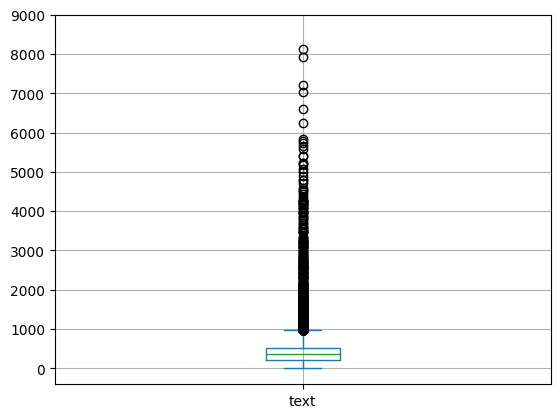

In [6]:
# Distribution of text number of words
text_len_series = df_full['text'].apply(lambda x: len(x.split()))
print(text_len_series.quantile([0.2,0.5,0.9,0.95,1]))

text_len_series.plot.box(yticks=np.arange(0,10000, step=1000), grid=True)

Half of the texts have at least around 370 words and 90% of the texts have around 750 words. Seems like texts are mostly long enough for tokenizer use too. After this quick exploration, let's start with NLP!

## NLP

In [7]:
class TextPreprocessor:
    def __init__(self, language='english'):
        self.stop_words = set(stopwords.words(language))
        self.lemmatizer = WordNetLemmatizer()

    def NormalizeTextCol(self, text):
        """Run the entire pipeline (normalize, tokenize, remove stopwords, lemmatize)."""
        text = self.normalize_text(text)
        tokens = self.tokenize(text)
        tokens = self.remove_stopwords(tokens)
        # tokens = self.lemmatize_tokens(tokens)
        return tokens

    def normalize_text(self, text):
        """Normalize the text by converting to lowercase and removing punctuation and digits."""
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation and special characters
        text = re.sub(r'\d+', '', text)  # Remove numbers
        return text

    def tokenize(self, text):
        """Tokenize the text into individual words."""
        return word_tokenize(text)

    def remove_stopwords(self, tokens):
        """Remove stopwords from the tokenized text."""
        return [word for word in tokens if word not in self.stop_words]

    def lemmatize_tokens(self, tokens):
        """Lemmatize the tokens."""
        return [self.lemmatizer.lemmatize(word) for word in tokens]

In [8]:
class_text_normalizer = TextPreprocessor()

In [10]:
df_train['pre_processed_title'] = df_train['title'].apply(class_text_normalizer.NormalizeTextCol)
df_train['pre_processed_text'] = df_train['text'].apply(class_text_normalizer.NormalizeTextCol)

df_eval['pre_processed_title'] = df_eval['title'].apply(class_text_normalizer.NormalizeTextCol)
df_eval['pre_processed_text'] = df_eval['text'].apply(class_text_normalizer.NormalizeTextCol)

df_test['pre_processed_title'] = df_test['title'].apply(class_text_normalizer.NormalizeTextCol)
df_test['pre_processed_text'] = df_test['text'].apply(class_text_normalizer.NormalizeTextCol)

In [ ]:
title_tokenizer = Tokenizer()
title_tokenizer.fit_on_texts(df_train['processed_title'].apply(lambda x: ' '.join(x)))

text_tokenizer = Tokenizer()
text_tokenizer.fit_on_texts(df_train['processed_text'].apply(lambda x: ' '.join(x)))

# Future code to be used

In [ ]:
# Convert titles and texts to sequences
train_title_sequences = tokenizer.texts_to_sequences(train_df['processed_title'].apply(lambda x: ' '.join(x)))
train_text_sequences = tokenizer.texts_to_sequences(train_df['processed_text'].apply(lambda x: ' '.join(x)))
test_title_sequences = tokenizer.texts_to_sequences(test_df['processed_title'].apply(lambda x: ' '.join(x)))
test_text_sequences = tokenizer.texts_to_sequences(test_df['processed_text'].apply(lambda x: ' '.join(x)))

# Define maximum length for title and text
max_title_length = 10
max_text_length = 20

# Pad sequences to ensure consistent input size
X_train_title = pad_sequences(train_title_sequences, maxlen=max_title_length, padding='post')
X_train_text = pad_sequences(train_text_sequences, maxlen=max_text_length, padding='post')
X_test_title = pad_sequences(test_title_sequences, maxlen=max_title_length, padding='post')
X_test_text = pad_sequences(test_text_sequences, maxlen=max_text_length, padding='post')

y_train = train_df['label'].values
y_test = test_df['label'].values

# Define the LSTM model with two inputs for 'title' and 'text'
title_input = Input(shape=(max_title_length,), name='Title_Input')
text_input = Input(shape=(max_text_length,), name='Text_Input')

# Embedding and LSTM layers for each input
embedding_layer_title = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50)(title_input)
lstm_title = LSTM(64)(embedding_layer_title)

embedding_layer_text = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=50)(text_input)
lstm_text = LSTM(128)(embedding_layer_text)

# Combine the outputs of both LSTM layers
combined = Concatenate()([lstm_title, lstm_text])

# Add a dense output layer for binary classification
output = Dense(1, activation='sigmoid')(combined)

# Build the model
model = Model(inputs=[title_input, text_input], outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(
    [X_train_title, X_train_text], y_train,
    epochs=5, batch_size=8, validation_split=0.2, verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test_title, X_test_text], y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")